Install pyspark

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 20 kB/s 
     |████████████████████████████████| 198 kB 54.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=f01072fb344456a9bf4c97f78cf2b71a63de83d644b6777792f3b8302045cef5
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


Initiate the spark context

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .master('local[*]')\
        .getOrCreate()
sc = spark.sparkContext

Mount your Google Drive and change the working directory

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/big-data-colab/Project
!ls

/content/drive/My Drive/Colab Notebooks/big-data-colab/Project
'Amazon Data.csv'  'Big Data Project.ipynb'


Importing Libraries

In [5]:
#For Avoding the warning
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
#For data analysis and data manipulation
import pandas as pd
#Multidimensional array objects and a collection of routines for processing those arrays
import numpy as np
# Using for machine learning library
import pyspark
#For getting null value, count
from pyspark.sql.functions import isnan, when, count, col
#For 2D Graphs
import matplotlib.pyplot as plt
#For #D Graphs
import seaborn as sns
%matplotlib inline
#For Interactive Graphs
import plotly.express as px
import plotly.graph_objects as go
import re

Reading the File

In [6]:
input_dir = '/content/drive/My Drive/Colab Notebooks/big-data-colab/Project/'
data = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema = 'true').load(input_dir + 'Amazon Data.csv')
data.columns

['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre']

In [7]:
#Seeing the dataset
pd.DataFrame(data.take(5), columns = data.columns)

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


In [8]:
#Type of DataFrame
type(data)

pyspark.sql.dataframe.DataFrame

In [9]:
#How many Rows and Column in the dataset
print((data.count(), len(data.columns)))

(550, 7)


In [10]:
#Information
data.printSchema()  

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genre: string (nullable = true)



In [11]:
data.summary()

DataFrame[summary: string, Name: string, Author: string, User Rating: string, Reviews: string, Price: string, Year: string, Genre: string]

In [12]:
# Basics stats from our columns
data.describe().toPandas()

,summary,Name,Author,User Rating,Reviews,Price,Year,Genre
0,count,550,550,550,550,550,550,550
1,mean,None,None,4.618363636363641,11953.281818181818,13.1,2014.0,None
2,stddev,None,None,0.22698036502519656,11731.132017431892,10.842261978422364,3.1651563841692782,None
3,min,"""The Plant Paradox: The Hidden Dangers in """"He...",Abraham Verghese,3.3,37,0,2009,Fiction
4,max,You Are a Badass: How to Stop Doubting Your Gr...,Zhi Gang Sha,4.9,87841,105,2019,Non Fiction


Data Pre-Processing

In [13]:
#Checking the Datatype
from pyspark.sql.functions import col
df = data.select(col('Name').cast('string'),col('Author').cast('string'),col('User Rating').cast('double'),col('Reviews').cast('integer'),col('Price').cast('integer'),col('Year').cast('integer'),col('Genre').cast('string'))
df.show()

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|        4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|        4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|

In [14]:
#Checking the null value
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----+------+-----------+-------+-----+----+-----+
|Name|Author|User Rating|Reviews|Price|Year|Genre|
+----+------+-----------+-------+-----+----+-----+
|   0|     0|          0|      0|    0|   0|    0|
+----+------+-----------+-------+-----+----+-----+



In [15]:
#Converting to pandas for data pre-processing and visualization
df = data.toPandas()

1. Correcting author names 

In [16]:
# Incorrectly Formatted Author Names
df["Author"] = df["Author"].replace(
    ["J. K. Rowling", "George R. R. Martin","R. J. Palacio","E L James", "JJ Smith"],
    ["J.K. Rowling", "George R.R. Martin","R.J. Palacio", "E.L. James", "J.J. Smith"])

In [17]:
#Checking the changex
df.loc[df['Author']=='George R. R. Martin']

,Name,Author,User Rating,Reviews,Price,Year,Genre


2. Correcting name of books

In [18]:
name = list(df.Name.sort_values().unique())
name

['"The Plant Paradox: The Hidden Dangers in ""Healthy"" Foods That Cause Disease and Weight Gain"',
 '10-Day Green Smoothie Cleanse',
 '11/22/63: A Novel',
 '12 Rules for Life: An Antidote to Chaos',
 '1984 (Signet Classics)',
 '5,000 Awesome Facts (About Everything!) (National Geographic Kids)',
 'A Dance with Dragons (A Song of Ice and Fire)',
 'A Game of Thrones / A Clash of Kings / A Storm of Swords / A Feast of Crows / A Dance with Dragons',
 'A Gentleman in Moscow: A Novel',
 'A Higher Loyalty: Truth, Lies, and Leadership',
 'A Man Called Ove: A Novel',
 "A Patriot's History of the United States: From Columbus's Great Discovery to the War on Terror",
 'A Stolen Life: A Memoir',
 'A Wrinkle in Time (Time Quintet)',
 'Act Like a Lady, Think Like a Man: What Men Really Think About Love, Relationships, Intimacy, and Commitment',
 'Adult Coloring Book Designs: Stress Relief Coloring Book: Garden Designs, Mandalas, Animals, and Paisley Patterns',
 'Adult Coloring Book: Stress Relieving

In [19]:
# Incomplete or Improperly Capitalized Book Titles
df["Name"] = df["Name"].replace(
    "JOURNEY TO THE ICE P",
    "Journey to the Ice Palace (Disney Frozen: Jumbo Coloring Book)")

df["Name"] = df["Name"].replace(
    "The 5 Love Languages: The Secret to Love That Lasts",
    "The 5 Love Languages: The Secret to Love that Lasts")

In [20]:
df.loc[(df['Name']=='Eclipse (Twilight Sagas)')|(df['Name']=='Eclipse (Twilight)')]

,Name,Author,User Rating,Reviews,Price,Year,Genre
95,Eclipse (Twilight Sagas),Stephenie Meyer,4.7,5505,7,2009,Fiction
96,Eclipse (Twilight),Stephenie Meyer,4.7,5505,18,2009,Fiction


In [21]:
sample1=df[(df['Name']!='Eclipse (Twilight)')]
sample1=sample1.drop_duplicates(subset='Name',keep='first',inplace=False)

3. Prices was zero

In [22]:
price = list(df.Price.unique())
print(price)
sorted(price)

[8, 22, 15, 6, 12, 11, 30, 3, 2, 32, 5, 17, 4, 13, 14, 9, 24, 21, 18, 0, 28, 16, 10, 105, 20, 1, 7, 19, 54, 52, 25, 27, 46, 39, 53, 40, 36, 82, 23, 42]


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 30,
 32,
 36,
 39,
 40,
 42,
 46,
 52,
 53,
 54,
 82,
 105]

In [23]:
df.loc[df['Price']==0]

,Name,Author,User Rating,Reviews,Price,Year,Genre
42,"Cabin Fever (Diary of a Wimpy Kid, Book 6)",Jeff Kinney,4.8,4505,0,2011,Fiction
71,"Diary of a Wimpy Kid: Hard Luck, Book 8",Jeff Kinney,4.8,6812,0,2013,Fiction
116,Frozen (Little Golden Book),RH Disney,4.7,3642,0,2014,Fiction
193,Journey to the Ice Palace (Disney Frozen: Jumb...,RH Disney,4.6,978,0,2014,Fiction
219,Little Blue Truck,Alice Schertle,4.9,1884,0,2014,Fiction
358,The Constitution of the United States,Delegates of the Constitutional,4.8,2774,0,2016,Non Fiction
381,The Getaway,Jeff Kinney,4.8,5836,0,2017,Fiction
461,The Short Second Life of Bree Tanner: An Eclip...,Stephenie Meyer,4.6,2122,0,2010,Fiction
505,To Kill a Mockingbird,Harper Lee,4.8,26234,0,2013,Fiction
506,To Kill a Mockingbird,Harper Lee,4.8,26234,0,2014,Fiction


In [24]:
sample_drop0price=df[(df['Price']!=0)]
sample_drop0price.loc[sample_drop0price['Price']==0]

,Name,Author,User Rating,Reviews,Price,Year,Genre


Data Visualizition

1. Count of Genre Column

In [25]:
#Grouping the type of Genre and taking the count
df1 = pd.DataFrame(df.groupby(by = ['Genre']).size().reset_index(name = 'count'))
#Getting count of Genre
fig = px.pie(df1, values="count" , names ="Genre",color_discrete_sequence = px.colors.sequential.RdBu, template = "plotly_dark")
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',title = 'Count of Genre')
fig.show()

2. Distribution of genres across all years

In [26]:
# Genre distribution across all years 2D density heatmap with number labels
fig = px.density_heatmap(df, x="Year", y="Genre", nbinsx=11, text_auto=True)
fig.update_layout(title=dict(text="Distribution of Genres across All Years"))
fig.update_layout(xaxis={'side': 'top'})
fig.update_layout(xaxis=dict(tickmode="linear",tick0=0,dtick=1))
fig.update_layout(margin=dict(t=120))
fig.update_traces(textfont_size=14)
fig.show()

3.Which Authors have appeared in the bestselling list more frequently

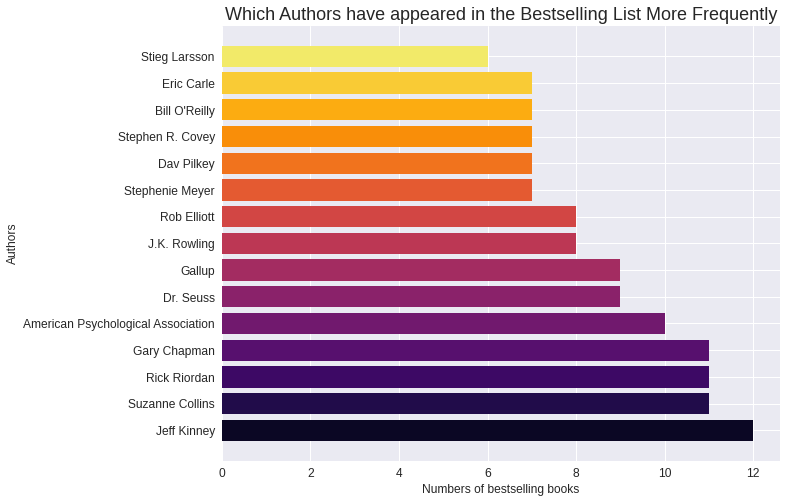

In [27]:
num_books_written = df.groupby('Author')[['Name']].count().sort_values('Name', ascending=False).head(15).reset_index()
plt.style.use("seaborn")
palette = sns.color_palette("inferno", 15)
plt.figure(figsize=(10,8))
plt.barh(y=num_books_written['Author'],width=num_books_written['Name'], color=palette)
plt.xlabel('Numbers of bestselling books', fontsize=12)
plt.ylabel('Authors', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.title('Which Authors have appeared in the Bestselling List More Frequently',fontsize=18)
#plt.grid()
plt.show()

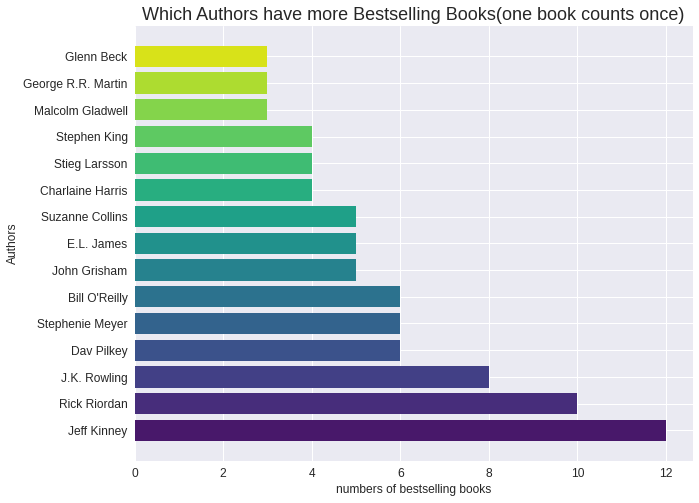

In [28]:
sample1=df[(df['Name']!='Eclipse (Twilight)')]
sample1=sample1.drop_duplicates(subset='Name',keep='first',inplace=False)
plt.style.use("seaborn")
palette = sns.color_palette("viridis",15)
num_books= sample1.groupby('Author')[['Name']].count().sort_values('Name', ascending=False).head(15).reset_index()
plt.figure(figsize=(10,8))
plt.barh(y=num_books['Author'],width=num_books['Name'], color=palette)
plt.xlabel('numbers of bestselling books', fontsize=12)
plt.ylabel('Authors', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.title('Which Authors have more Bestselling Books(one book counts once)',fontsize=18)
plt.show()

In [29]:
sample1.loc[(sample1['Author']=='Jeff Kinney')] 

,Name,Author,User Rating,Reviews,Price,Year,Genre
42,"Cabin Fever (Diary of a Wimpy Kid, Book 6)",Jeff Kinney,4.8,4505,0,2011,Fiction
71,"Diary of a Wimpy Kid: Hard Luck, Book 8",Jeff Kinney,4.8,6812,0,2013,Fiction
72,Diary of a Wimpy Kid: The Last Straw (Book 3),Jeff Kinney,4.8,3837,15,2009,Fiction
73,Diary of a Wimpy Kid: The Long Haul,Jeff Kinney,4.8,6540,22,2014,Fiction
80,"Dog Days (Diary of a Wimpy Kid, Book 4) (Volum...",Jeff Kinney,4.8,3181,12,2009,Fiction
88,Double Down (Diary of a Wimpy Kid #11),Jeff Kinney,4.8,5118,20,2016,Fiction
253,Old School (Diary of a Wimpy Kid #10),Jeff Kinney,4.8,6169,7,2015,Fiction
381,The Getaway,Jeff Kinney,4.8,5836,0,2017,Fiction
435,The Meltdown (Diary of a Wimpy Kid Book 13),Jeff Kinney,4.8,5898,8,2018,Fiction
468,"The Third Wheel (Diary of a Wimpy Kid, Book 7)",Jeff Kinney,4.7,6377,7,2012,Fiction


Jeff Kinney appeared in the list most often. And each time, he showed up due to a different book.

4.Which Authors have received the highest ratings in average

In [30]:
mean_rating_author = df.groupby('Author')[['User Rating']].mean().sort_values('User Rating', ascending=False).head(15).reset_index()
mean_rating_author.head(15)

,Author,User Rating
0,Nathan W. Pyle,4.900000
1,Sherri Duskey Rinker,4.900000
2,Jill Twiss,4.900000
3,Rush Limbaugh,4.900000
4,Pete Souza,4.900000
5,Sarah Young,4.900000
6,Patrick Thorpe,4.900000
7,Bill Martin Jr.,4.900000
8,Dav Pilkey,4.900000
9,Alice Schertle,4.900000


In [31]:
df.loc[(df['Author']=='Nathan W. Pyle') | (df['Author']=='Sherri Duskey Rinker')| (df['Author']=='Jill Twiss')]

,Name,Author,User Rating,Reviews,Price,Year,Genre
146,"Goodnight, Goodnight Construction Site (Hardco...",Sherri Duskey Rinker,4.9,7038,7,2012,Fiction
147,"Goodnight, Goodnight Construction Site (Hardco...",Sherri Duskey Rinker,4.9,7038,7,2013,Fiction
207,Last Week Tonight with John Oliver Presents A ...,Jill Twiss,4.9,11881,13,2018,Fiction
303,Strange Planet (Strange Planet Series),Nathan W. Pyle,4.9,9382,6,2019,Fiction


We can see the highest 14 mean ratings are all equal to 4.90----Mostly because the author was in the list due to the same bestselling book.

In [32]:
df.loc[(df['Author']=='Dr. Seuss') | (df['Author']=='Eric Carle')]

,Name,Author,User Rating,Reviews,Price,Year,Genre
245,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2012,Fiction
246,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2013,Fiction
247,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2014,Fiction
248,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2015,Fiction
249,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2016,Fiction
250,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2017,Fiction
251,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2018,Fiction
252,"Oh, the Places You'll Go!",Dr. Seuss,4.9,21834,8,2019,Fiction
476,The Very Hungry Caterpillar,Eric Carle,4.9,19546,5,2013,Fiction
477,The Very Hungry Caterpillar,Eric Carle,4.9,19546,5,2014,Fiction


Comparing the two plots above, only two authors have appeared in both plots: Dr. Seuss and Eric Carle.
Thus considering two categories, the numbers and ratings, 'Oh, the Places You'll Go!' by Dr. Seuss and 'The Very Hungry Caterpillar' by Eric Carle are the most popular in the long term

5. What are the annual mean prices like?

In [33]:
sample_drop0price=df[(df['Price']!=0)]
meanprice_year = sample_drop0price.groupby('Year')[['Price']].mean().sort_values('Price', ascending=False).head(15)
meanprice_year = meanprice_year.sort_values('Year',ascending=True)
print('Overall mean price is')
print(meanprice_year['Price'].mean())
meanprice_year.head(15)

Overall mean price is
13.414427885778819


,Price
Year,
2009,15.400000
2010,13.755102
2011,15.408163
2012,15.300000
2013,15.208333
2014,15.913043
2015,10.632653
2016,13.729167
2017,11.612245


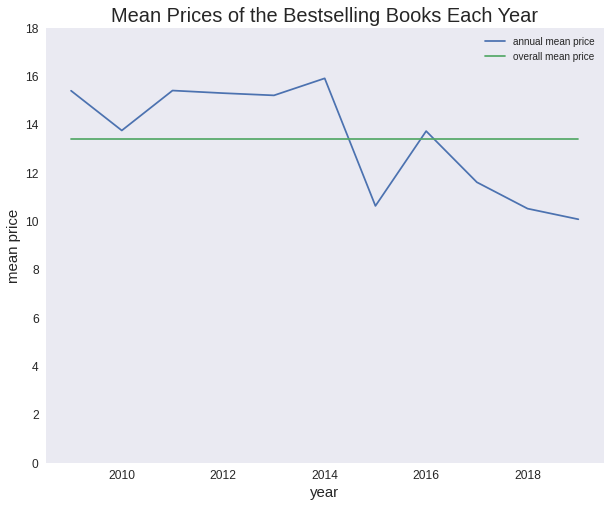

In [34]:
plt.figure(figsize=(10,8))
plt.plot(meanprice_year,label='annual mean price')
x=np.linspace(2009,2019,11)
y=x*0+meanprice_year['Price'].mean()
plt.plot(x,y,label='overall mean price')
plt.ylim(0,18)
plt.xlabel('year', fontsize=15)
plt.ylabel('mean price', fontsize=15)
plt.tick_params(axis='both', labelsize=12)
plt.title('Mean Prices of the Bestselling Books Each Year',fontsize=20)
plt.legend()
plt.grid()
plt.show()

Though fluctuating, the annual mean prices did not wave dramatically.
Also, we can observe the overall trending is going down, implying the prices of bestselling books are decreasing in recent years.

6.What are the top 10 most expensive bestselling books?

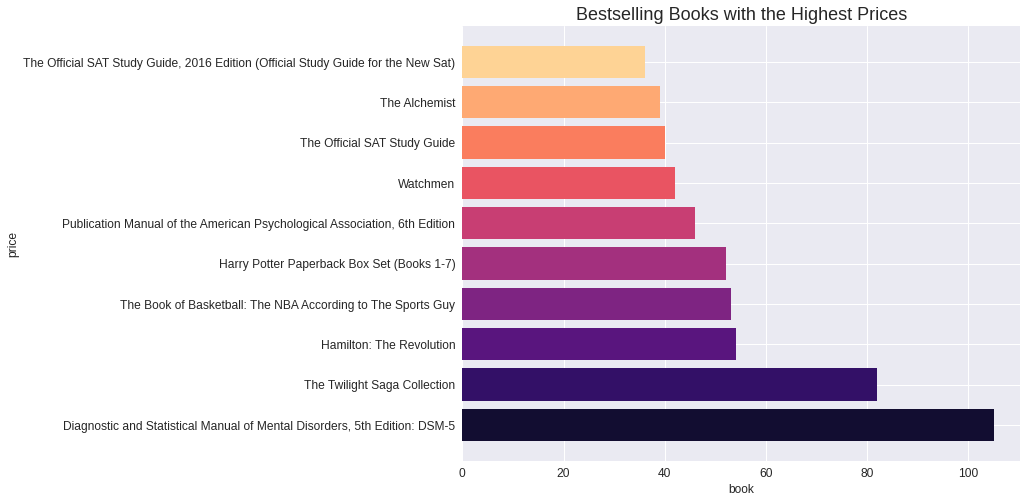

In [35]:
meanprice_book = df.groupby('Name')[['Price']].mean().sort_values('Price', ascending=False).head(10).reset_index()
plt.style.use("seaborn")
palette = sns.color_palette("magma",10)
plt.figure(figsize=(10,8))
plt.barh(y=meanprice_book['Name'],width=meanprice_book['Price'],color=palette)
plt.xlabel('book', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.title('Bestselling Books with the Highest Prices',fontsize=18)
plt.show()

7. What are the annual mean ratings like?

In [36]:
mean_rating_year = df.groupby('Year')[['User Rating']].mean().sort_values('User Rating', ascending=False).head(11)
mean_rating_year = mean_rating_year.sort_values('Year',ascending=True)
print('Overall mean rating is')
print(mean_rating_year['User Rating'].mean())
mean_rating_year.head(15)

Overall mean rating is
4.618363636363636


,User Rating
Year,
2009,4.584
2010,4.558
2011,4.558
2012,4.532
2013,4.554
2014,4.622
2015,4.648
2016,4.678
2017,4.660


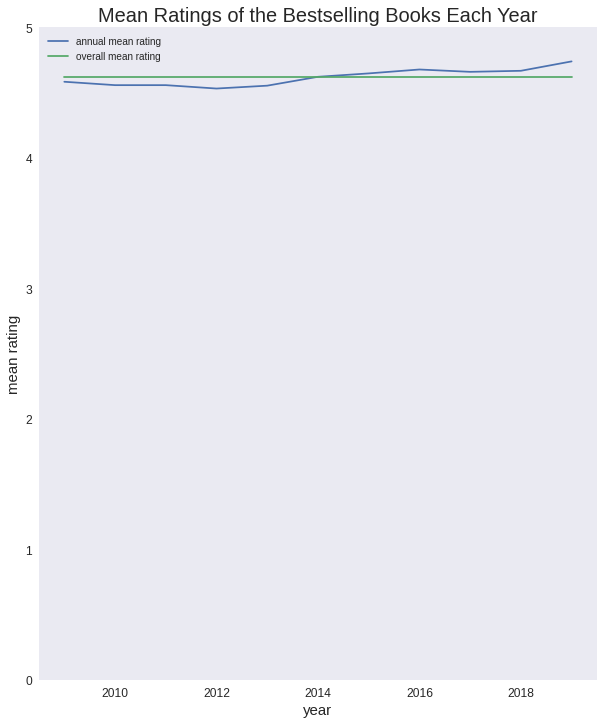

In [37]:
plt.figure(figsize=(10,12))
plt.plot(mean_rating_year,label='annual mean rating')
x=np.linspace(2009,2019,11)
y=x*0+ mean_rating_year['User Rating'].mean()
plt.plot(x,y,label='overall mean rating')
plt.ylim(0,5)
plt.xlabel('year', fontsize=15)
plt.ylabel('mean rating', fontsize=15)
plt.tick_params(axis='both', labelsize=12)
plt.title('Mean Ratings of the Bestselling Books Each Year',fontsize=20)
plt.legend()
plt.grid()
plt.show()

We can observe that the annual mean ratings are quite close, fluctuating between 4.5 and 4.8.
Thus we could say that averagely, the quality of the bestselling books are guaranteed.
Considering the highest rating is 4.9, let's see what the books with rating 4.9 are like

8. Are more of those highest-rated books fictional or non-fictional?

In [38]:
df.loc[df['User Rating'] == 4.9]

,Name,Author,User Rating,Reviews,Price,Year,Genre
40,"Brown Bear, Brown Bear, What Do You See?",Bill Martin Jr.,4.9,14344,5,2017,Fiction
41,"Brown Bear, Brown Bear, What Do You See?",Bill Martin Jr.,4.9,14344,5,2019,Fiction
81,Dog Man and Cat Kid: From the Creator of Capta...,Dav Pilkey,4.9,5062,6,2018,Fiction
82,Dog Man: A Tale of Two Kitties: From the Creat...,Dav Pilkey,4.9,4786,8,2017,Fiction
83,Dog Man: Brawl of the Wild: From the Creator o...,Dav Pilkey,4.9,7235,4,2018,Fiction
84,Dog Man: Brawl of the Wild: From the Creator o...,Dav Pilkey,4.9,7235,4,2019,Fiction
85,Dog Man: Fetch-22: From the Creator of Captain...,Dav Pilkey,4.9,12619,8,2019,Fiction
86,Dog Man: For Whom the Ball Rolls: From the Cre...,Dav Pilkey,4.9,9089,8,2019,Fiction
87,Dog Man: Lord of the Fleas: From the Creator o...,Dav Pilkey,4.9,5470,6,2018,Fiction
146,"Goodnight, Goodnight Construction Site (Hardco...",Sherri Duskey Rinker,4.9,7038,7,2012,Fiction


In [39]:
highest_rating=df[(df['User Rating']==4.9)] # filtering
#drop duplicates
highest_rating=highest_rating.drop_duplicates(subset='Name',keep='first',inplace=False)
highest_rating.head(10)

,Name,Author,User Rating,Reviews,Price,Year,Genre
40,"Brown Bear, Brown Bear, What Do You See?",Bill Martin Jr.,4.9,14344,5,2017,Fiction
81,Dog Man and Cat Kid: From the Creator of Capta...,Dav Pilkey,4.9,5062,6,2018,Fiction
82,Dog Man: A Tale of Two Kitties: From the Creat...,Dav Pilkey,4.9,4786,8,2017,Fiction
83,Dog Man: Brawl of the Wild: From the Creator o...,Dav Pilkey,4.9,7235,4,2018,Fiction
85,Dog Man: Fetch-22: From the Creator of Captain...,Dav Pilkey,4.9,12619,8,2019,Fiction
86,Dog Man: For Whom the Ball Rolls: From the Cre...,Dav Pilkey,4.9,9089,8,2019,Fiction
87,Dog Man: Lord of the Fleas: From the Creator o...,Dav Pilkey,4.9,5470,6,2018,Fiction
146,"Goodnight, Goodnight Construction Site (Hardco...",Sherri Duskey Rinker,4.9,7038,7,2012,Fiction
151,Hamilton: The Revolution,Lin-Manuel Miranda,4.9,5867,54,2016,Non Fiction
153,Harry Potter and the Chamber of Secrets: The I...,J.K. Rowling,4.9,19622,30,2016,Fiction


In [40]:
Genre = highest_rating.groupby('Genre')[['Name']].count().sort_values('Name', ascending=False).head(11)
Genre.head()

,Name
Genre,
Fiction,22
Non Fiction,6


9.Percentages of Fiction and Non Fiction among books with the highest rating

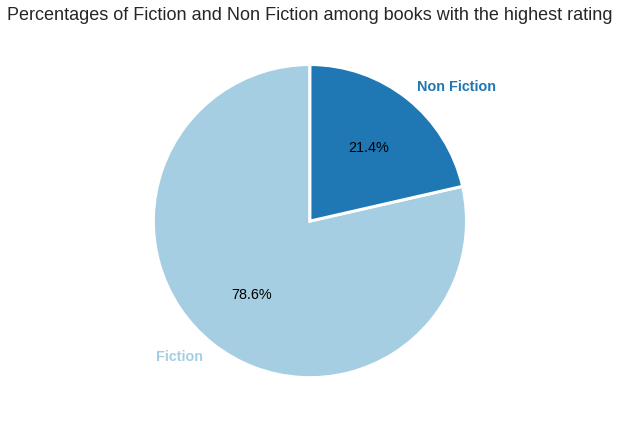

In [41]:
plt.style.use("seaborn")
palette = sns.color_palette("Paired",2)
fig, ax = plt.subplots(figsize=(8, 6))
patches, texts, pcts = ax.pie(x=[22,6], labels=['Fiction','Non Fiction'],colors=palette ,autopct='%.1f%%',wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},textprops={'size': 'x-large'},startangle=90)
# For each wedge, set the corresponding text label color to the wedge's
# face color.
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='black')
plt.setp(texts, fontweight=600)
ax.set_title('Percentages of Fiction and Non Fiction among books with the highest rating',fontsize=18)
plt.tight_layout()
plt.show()

10.Percentages of Fiction and Non Fiction among all the Bestselling Books

In [42]:
# sample1 instead of df
Genre = sample1.groupby('Genre')[['Name']].count().sort_values('Name', ascending=False).head(11)
Genre.head()

,Name
Genre,
Non Fiction,190
Fiction,159


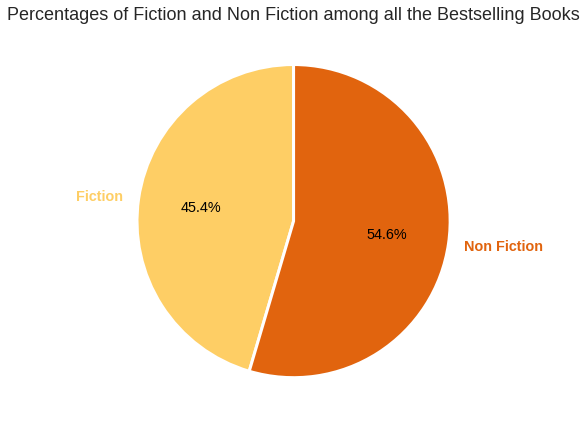

In [43]:
plt.style.use("seaborn")
palette = sns.color_palette("YlOrBr",2)
fig, ax = plt.subplots(figsize=(8, 6))
patches, texts, pcts = ax.pie(x=[159,191], labels=['Fiction','Non Fiction'],colors=palette ,autopct='%.1f%%',wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},textprops={'size': 'x-large'},startangle=90)
# For each wedge, set the corresponding text label color to the wedge's
# face color.
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='black')
plt.setp(texts, fontweight=600)
ax.set_title('Percentages of Fiction and Non Fiction among all the Bestselling Books',fontsize=18)
plt.tight_layout()
plt.show()

While there are more than three quarters fictional books among the highest rated books,
the overall percentage of fiction is less than a half.

Though fictional books are less than non fictional books, they have received much more reviews from readers on Amazon, implying the popularity among readers as well as readers' preference.

In [44]:
num_reviews = sample1.groupby('Genre')[['User Rating']].mean().sort_values('User Rating', ascending=False).head(15).reset_index()
num_reviews.head(15)

,Genre,User Rating
0,Fiction,4.615094
1,Non Fiction,4.602105


11.What is the correlation between price and rating?

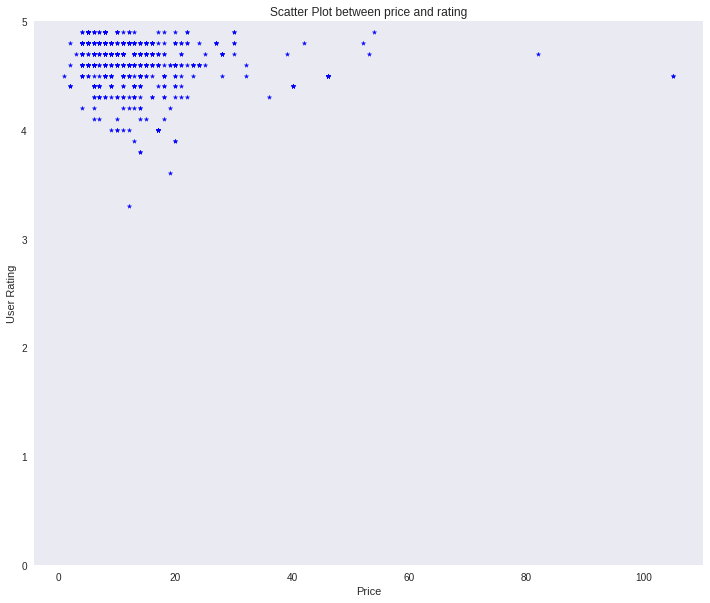

In [45]:
sample_drop0price.plot.scatter(x='Price', y='User Rating', color='blue',marker='*',s=20,figsize=(12,10))
plt.ylim(0,5)
plt.title('Scatter Plot between price and rating')
plt.grid()

clustered in the upper left corner----nonlinear relationship, and not highly-correlated
implying that books won't become more expensive just because of higher ratings.
or be devaluated due to poor ratings

12.What is the correlation between rating and number of reviews?

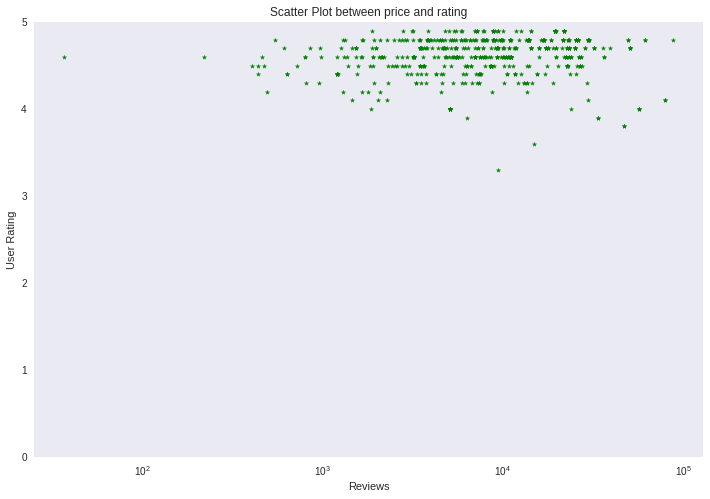

In [46]:
df.plot.scatter(x='Reviews', y='User Rating',logx=True, color='green',marker='*',s=20,figsize=(12,8))
plt.ylim(0,5)
plt.title('Scatter Plot between price and rating')
plt.grid()

Also, nonlinear relationship, and not highly-correlated
We could interpret that large number of reviews won't make a difference to book ratings.

In [47]:
top_20_reviews = df.sort_values('Reviews', ascending=False)[:20]
top_20_reviews

,Name,Author,User Rating,Reviews,Price,Year,Genre
534,Where the Crawdads Sing,Delia Owens,4.8,87841,15,2019,Fiction
382,The Girl on the Train,Paula Hawkins,4.1,79446,18,2015,Fiction
383,The Girl on the Train,Paula Hawkins,4.1,79446,7,2016,Fiction
32,Becoming,Michelle Obama,4.8,61133,11,2018,Non Fiction
33,Becoming,Michelle Obama,4.8,61133,11,2019,Non Fiction
137,Gone Girl,Gillian Flynn,4.0,57271,9,2014,Fiction
135,Gone Girl,Gillian Flynn,4.0,57271,10,2012,Fiction
136,Gone Girl,Gillian Flynn,4.0,57271,10,2013,Fiction
368,The Fault in Our Stars,John Green,4.7,50482,13,2014,Fiction
367,The Fault in Our Stars,John Green,4.7,50482,7,2014,Fiction


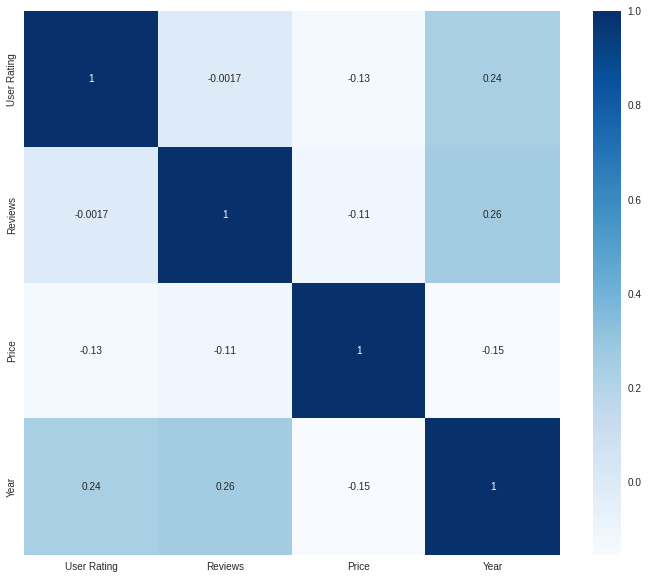

In [48]:
#Seeing the correlation for each feature using the heatmap
fig, ax = plt.subplots(figsize=(12,10))
fig.patch.set_facecolor('white')
sns.heatmap(df.corr(), ax=ax, annot=True, cmap="Blues")

In [49]:
df

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,J.J. Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction
...,...,...,...,...,...,...,...
545,Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,2019,Fiction
546,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2016,Non Fiction
547,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2017,Non Fiction
548,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2018,Non Fiction


In [50]:
#Copying to Spark dataframe whichever data pre-processing we did.
data =spark.createDataFrame(df) 

In [51]:
data.show()

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|          J.J. Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...|  George R.R. Martin|        4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...|  George R.R. Martin|        4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|

'Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre'

Preparing Data for Algorithm

In [52]:
cols = data.columns

Coverting the catogrical variable using One Hot Encoding 

In [53]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['Name', 'Author','Genre']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'Genre', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['User Rating', 'Reviews', 'Price', 'Year']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Creating the Pipeline for Feature and label

In [54]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data)
data = pipelineModel.transform(data)
selectedCols = ['label', 'features'] + cols
data = data.select(selectedCols)
data.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: double (nullable = true)
 |-- Reviews: long (nullable = true)
 |-- Price: long (nullable = true)
 |-- Year: long (nullable = true)
 |-- Genre: string (nullable = true)



In [55]:
pd.DataFrame(data.take(5), columns=data.columns).transpose()

,0,1,2,3,4
label,0.0,1.0,0.0,1.0,0.0
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Name,10-Day Green Smoothie Cleanse,11/22/63: A Novel,12 Rules for Life: An Antidote to Chaos,1984 (Signet Classics),"5,000 Awesome Facts (About Everything!) (Natio..."
Author,J.J. Smith,Stephen King,Jordan B. Peterson,George Orwell,National Geographic Kids
User Rating,4.7,4.6,4.7,4.7,4.8
Reviews,17350,2052,18979,21424,7665
Price,8,22,15,6,12
Year,2016,2011,2018,2017,2019
Genre,Non Fiction,Fiction,Non Fiction,Fiction,Non Fiction


Spliting Data into Training and Testing Data

In [178]:
train, test = data.randomSplit([0.7, 0.3], seed = 123)
print("Training Dataset Count: " + str(train.count()))
print("Testing Dataset Count: " + str(test.count()))

Training Dataset Count: 395
Testing Dataset Count: 155


In [179]:
#from pyspark.ml.feature import StandardScaler
#scaler =  StandardScaler(inputCol = 'features', withStd = True, withMean = True) 
#scalerModel = scaler.fit(train) 
#scaledData = scalerModel.transform(train)

In [180]:
#For Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [181]:
bcEvaluator = BinaryClassificationEvaluator()
mcEvaluator = MulticlassClassificationEvaluator()

1. Navie Bayes

In [182]:
from pyspark.ml.classification import NaiveBayes
#Creating the variable for model
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')
#Fitting the model
nbModel = nb.fit(train)
#Predict on Train
NB_Train_Predicition = nbModel.transform(train)
#Predict on Test
NB_Test_Prediction = nbModel.transform(test)

In [183]:
print("NB Model Accuracy(in %) for Training:", mcEvaluator.evaluate(NB_Train_Predicition)*100)
print("NB Model Accuracy(in %) for Testing:", mcEvaluator.evaluate(NB_Test_Prediction)*100)

NB Model Accuracy(in %) for Training: 61.49591768220347
NB Model Accuracy(in %) for Testing: 65.0135577372604


In [184]:
NB_Test_Prediction.select(['label','prediction', 'probability']).show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[1.0,2.9735846998...|
|  0.0|       1.0|[5.33543492359707...|
|  0.0|       1.0|[2.31269486763369...|
|  0.0|       1.0|[8.69909913507856...|
|  0.0|       1.0|[1.41837298177623...|
|  0.0|       1.0|           [0.0,1.0]|
|  0.0|       0.0|[1.0,1.7166302037...|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|[1.0,2.3287279232...|
|  0.0|       0.0|[1.0,1.4282445678...|
|  0.0|       1.0|[3.27328500960558...|
|  0.0|       0.0|[1.0,2.4635697678...|
|  0.0|       0.0|[1.0,9.2668583865...|
|  0.0|       0.0|[1.0,4.7973753825...|
|  0.0|       0.0|[1.0,5.0608053641...|
|  0.0|       1.0|[1.44663532144315...|
|  0.0|       0.0|[1.0,2.092856557E...|
|  0.0|       0.0|[1.0,3.2269109142...|
|  0.0|       0.0|[1.0,2.0672177360...|
+-----+----------+--------------------+
only showing top 20 rows



In [185]:
NB_y_true = NB_Test_Prediction.select(['label']).collect()
NB_y_pred = NB_Test_Prediction.select(['prediction']).collect()

In [186]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
NB_Overall_Accuracy = my_mc_nb.evaluate(NB_Test_Prediction)*100
print("Overall Accuracy for Naive Bayes: " ,NB_Overall_Accuracy)

Overall Accuracy for Naive Bayes:  65.80645161290323


In [187]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
NB_f1_Score = my_mc_nb.evaluate(NB_Test_Prediction)*100
print("F1 Score for Naive Bayes: " ,NB_f1_Score)

F1 Score for Naive Bayes:  65.0135577372604


In [188]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedRecall')
NB_recall = my_mc_nb.evaluate(NB_Test_Prediction)*100
print("Recall for Naive Bayes: " ,NB_recall)

Recall for Naive Bayes:  65.80645161290323


In [189]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedPrecision')
NB_percision = my_mc_nb.evaluate(NB_Test_Prediction)*100
print("Percision for Naive Bayes: " ,NB_percision)

Percision for Naive Bayes:  65.1786843769766


In [190]:
my_eval_nb = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
NB_ROC = my_eval_nb.evaluate(NB_Test_Prediction)*100
print("ROC for Naive Bayes: " ,NB_ROC)

ROC for Naive Bayes:  63.229739010989015


In [191]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix For Navie Bayes:\n ",confusion_matrix(NB_y_true, NB_y_pred),"\n")
print("Classification Report For Navie Bayes:\n",classification_report(NB_y_true, NB_y_pred))

Confusion Matrix For Navie Bayes:
  [[71 20]
 [33 31]] 

Classification Report For Navie Bayes:
               precision    recall  f1-score   support

         0.0       0.68      0.78      0.73        91
         1.0       0.61      0.48      0.54        64

    accuracy                           0.66       155
   macro avg       0.65      0.63      0.63       155
weighted avg       0.65      0.66      0.65       155



2. Logistic Regression

In [192]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
LR_Train_Predicition = lrModel.transform(train)
LR_Test_Prediction = lrModel.transform(test)

In [193]:
print("LR Model Accuracy(in %) for Training:", mcEvaluator.evaluate(LR_Train_Predicition)*100)
print("LR Model Accuracy(in %) for Training:", mcEvaluator.evaluate(LR_Test_Prediction)*100)

LR Model Accuracy(in %) for Training: 100.0
LR Model Accuracy(in %) for Training: 99.35406144036332


In [194]:
LR_Test_Prediction.select(['label','prediction', 'probability']).show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.99972923173376...|
|  0.0|       0.0|[0.99965933345838...|
|  0.0|       0.0|[0.99969385004328...|
|  0.0|       0.0|[0.99967189145942...|
|  0.0|       0.0|[0.99968336973080...|
|  0.0|       0.0|[0.99967883831239...|
|  0.0|       0.0|[0.99970516896391...|
|  0.0|       0.0|[0.99968637014119...|
|  0.0|       0.0|[0.99969734205598...|
|  0.0|       0.0|[0.99971222274714...|
|  0.0|       0.0|[0.99972229049485...|
|  0.0|       0.0|[0.99965693531796...|
|  0.0|       0.0|[0.99969168484201...|
|  0.0|       0.0|[0.99971287969846...|
|  0.0|       0.0|[0.99982717161513...|
|  0.0|       0.0|[0.99968895794715...|
|  0.0|       0.0|[0.99968822143864...|
|  0.0|       0.0|[0.99971467199381...|
|  0.0|       0.0|[0.99972404805926...|
|  0.0|       0.0|[0.99967290872601...|
+-----+----------+--------------------+
only showing top 20 rows



In [195]:
LR_y_true = LR_Test_Prediction.select(['label']).collect()
LR_y_pred = LR_Test_Prediction.select(['prediction']).collect()

In [196]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
LR_Overall_Accuracy = my_mc_nb.evaluate(LR_Test_Prediction)*100
print("Overall Accuracy for Logistic Regression: " ,LR_Overall_Accuracy)

Overall Accuracy for Logistic Regression:  99.35483870967742


In [197]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
LR_f1_Score = my_mc_nb.evaluate(LR_Test_Prediction)*100
print("F1 Score for Logistic Regression: " ,LR_f1_Score)

F1 Score for Logistic Regression:  99.35406144036332


In [198]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedPrecision')
LR_percision = my_mc_nb.evaluate(LR_Test_Prediction)*100
print("Percision for Logistic Regression: " ,LR_percision)

Percision for Logistic Regression:  99.36185133239832


In [199]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedRecall')
LR_recall = my_mc_nb.evaluate(LR_Test_Prediction)*100
print("Recall for Logistic Regression: " ,LR_recall)

Recall for Logistic Regression:  99.35483870967741


In [200]:
my_eval_nb = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
LR_ROC = my_eval_nb.evaluate(LR_Test_Prediction)*100
print("ROC for Logistic Regression: " ,LR_ROC)

ROC for Logistic Regression:  99.21875


In [201]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix For Logistic Regression:\n ",confusion_matrix(LR_y_true, LR_y_pred),"\n")
print("Classification Report For Logistic Regression:\n",classification_report(LR_y_true, LR_y_pred))

Confusion Matrix For Logistic Regression:
  [[91  0]
 [ 1 63]] 

Classification Report For Logistic Regression:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99        91
         1.0       1.00      0.98      0.99        64

    accuracy                           0.99       155
   macro avg       0.99      0.99      0.99       155
weighted avg       0.99      0.99      0.99       155



3. Random Forest

In [202]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
RF_Train_Predicition = rfModel.transform(train)
RF_Test_Prediction = rfModel.transform(test)

In [203]:
print("RF Model Accuracy(in %) for Training:", mcEvaluator.evaluate(RF_Train_Predicition)*100)
print("RF Model Accuracy(in %) for Testing:", mcEvaluator.evaluate(RF_Test_Prediction)*100)

RF Model Accuracy(in %) for Training: 97.71456410761934
RF Model Accuracy(in %) for Testing: 94.11077790345999


In [204]:
RF_Test_Prediction.select(['label','prediction', 'probability']).show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.69039074346604...|
|  0.0|       0.0|[0.59722480321530...|
|  0.0|       0.0|[0.59722480321530...|
|  0.0|       0.0|[0.69102234703390...|
|  0.0|       0.0|[0.69102234703390...|
|  0.0|       0.0|[0.66058396820843...|
|  0.0|       0.0|[0.69102234703390...|
|  0.0|       0.0|[0.70890475948435...|
|  0.0|       0.0|[0.70890475948435...|
|  0.0|       0.0|[0.70738497164265...|
|  0.0|       0.0|[0.71479952094695...|
|  0.0|       0.0|[0.69102234703390...|
|  0.0|       0.0|[0.68360779772961...|
|  0.0|       0.0|[0.69102234703390...|
|  0.0|       0.0|[0.68360779772961...|
|  0.0|       0.0|[0.69039074346604...|
|  0.0|       0.0|[0.69102234703390...|
|  0.0|       0.0|[0.66265839352097...|
|  0.0|       0.0|[0.69102234703390...|
|  0.0|       0.0|[0.69039074346604...|
+-----+----------+--------------------+
only showing top 20 rows



In [205]:
RF_y_true = RF_Test_Prediction.select(['label']).collect()
RF_y_pred = RF_Test_Prediction.select(['prediction']).collect()

In [206]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
RF_Overall_Accuracy = my_mc_nb.evaluate(RF_Test_Prediction)*100
print("Overall Accuracy for Random Forest: " ,RF_Overall_Accuracy)

Overall Accuracy for Random Forest:  94.19354838709677


In [207]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
RF_f1_Score = my_mc_nb.evaluate(RF_Test_Prediction)*100
print("F1 Score for Random Forest: " ,RF_f1_Score)

F1 Score for Random Forest:  94.11077790345999


In [208]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedPrecision')
RF_percision = my_mc_nb.evaluate(RF_Test_Prediction)*100
print("Percision for Random Forest: " ,RF_percision)

Percision for Random Forest:  94.71612903225805


In [209]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedRecall')
RF_recall = my_mc_nb.evaluate(RF_Test_Prediction)*100
print("Percision for Random Forest: " ,RF_recall)

Percision for Random Forest:  94.19354838709677


In [210]:
my_eval_nb = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
RF_ROC = my_eval_nb.evaluate(RF_Test_Prediction)*100
print("ROC for Random Forest: " ,RF_ROC)

ROC for Random Forest:  92.96875


In [211]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix For Random Forest:\n ",confusion_matrix(RF_y_true, RF_y_pred),"\n")
print("Classification Report For Eandom Forest:\n",classification_report(RF_y_true, RF_y_pred))

Confusion Matrix For Random Forest:
  [[91  0]
 [ 9 55]] 

Classification Report For Eandom Forest:
               precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        91
         1.0       1.00      0.86      0.92        64

    accuracy                           0.94       155
   macro avg       0.96      0.93      0.94       155
weighted avg       0.95      0.94      0.94       155



4. Decision Tree

In [212]:
from pyspark.ml.classification import DecisionTreeClassifier
df = DecisionTreeClassifier( impurity='gini', maxDepth=5, maxBins=32,featuresCol = 'features', labelCol = 'label')
dfModel = df.fit(train)
DT_Train_Predicition = dfModel.transform(train)
DT_Test_Prediction = dfModel.transform(test)

In [213]:
print("Taining Accuracy:", mcEvaluator.evaluate(DT_Train_Predicition)*100)
print("Testing Accuracy:", mcEvaluator.evaluate(DT_Test_Prediction)*100)

Taining Accuracy: 100.0
Testing Accuracy: 100.0


In [214]:
DT_Test_Prediction.select(['label','prediction', 'probability']).show()

+-----+----------+-----------+
|label|prediction|probability|
+-----+----------+-----------+
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
|  0.0|       0.0|  [1.0,0.0]|
+-----+----------+-----------+
only showing top 20 rows



In [215]:
DT_y_true = DT_Test_Prediction.select(['label']).collect()
DT_y_pred = DT_Test_Prediction.select(['prediction']).collect()

In [216]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
DT_Overall_Accuracy = my_mc_nb.evaluate(DT_Test_Prediction)*100
print("Overall Accuracy for Decision Tree: " ,DT_Overall_Accuracy)

Overall Accuracy for Decision Tree:  100.0


In [217]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
DT_f1_Score = my_mc_nb.evaluate(DT_Test_Prediction)*100
print("F1 Score for DEcision Tree: " ,DT_f1_Score)

F1 Score for DEcision Tree:  100.0


In [218]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedPrecision')
DT_percision = my_mc_nb.evaluate(DT_Test_Prediction)*100
print("Percision for Decision Tree: " ,DT_percision)

Percision for Decision Tree:  100.0


In [219]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedRecall')
DT_recall = my_mc_nb.evaluate(DT_Test_Prediction)*100
print("Recall for Decision Tree: " ,DT_recall)

Recall for Decision Tree:  100.0


In [220]:
my_eval_nb = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
DT_ROC = my_eval_nb.evaluate(DT_Test_Prediction)*100
print("ROC for Decision Tree: " ,DT_ROC)

ROC for Decision Tree:  100.0


In [221]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix For Decision Tree:\n ",confusion_matrix(DT_y_true, DT_y_pred),"\n")
print("Classification Report For Decision Tree:\n",classification_report(DT_y_true, DT_y_pred))

Confusion Matrix For Decision Tree:
  [[91  0]
 [ 0 64]] 

Classification Report For Decision Tree:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        91
         1.0       1.00      1.00      1.00        64

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155
weighted avg       1.00      1.00      1.00       155



5. Support Vector Machine

In [235]:
from pyspark.ml.classification import LinearSVC
svc = LinearSVC(labelCol="label")
svcModel = svc.fit(train)
SVC_Train_Predicition = svcModel.transform(train)
SVC_Test_Prediction = svcModel.transform(test)

In [237]:
print("SVC Model Accuracy(in %) for Training", mcEvaluator.evaluate(SVC_Train_Predicition)*100)
print("SVC Model Accuracy(in %) for Testing:", mcEvaluator.evaluate(SVC_Test_Prediction)*100)

SVC Model Accuracy(in %) for Training 100.0
SVC Model Accuracy(in %) for Testing: 99.35406144036332


In [238]:
SVC_Test_Prediction.select(['label','prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [239]:
SVC_y_true = SVC_Test_Prediction.select(['label']).collect()
SVC_y_pred = SVC_Test_Prediction.select(['prediction']).collect()

In [240]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
SVC_Overall_Accuracy = my_mc_nb.evaluate(SVC_Test_Prediction)*100
print("Overall Accuracy for Support Vector Machine: " ,SVC_Overall_Accuracy)

Overall Accuracy for Support Vector Machine:  99.35483870967742


In [241]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
SVC_f1_Score = my_mc_nb.evaluate(SVC_Test_Prediction)*100
print("F1 Score for Support Vector Machine: " ,SVC_f1_Score)

F1 Score for Support Vector Machine:  99.35406144036332


In [242]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedPrecision')
SVC_percision = my_mc_nb.evaluate(SVC_Test_Prediction)*100
print("Percision for Support Vector Machine: " ,SVC_percision)

Percision for Support Vector Machine:  99.36185133239832


In [243]:
my_mc_nb = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedRecall')
SVC_recall = my_mc_nb.evaluate(SVC_Test_Prediction)*100
print("Recall for Support Vector Machine: " ,SVC_recall)

Recall for Support Vector Machine:  99.35483870967741


In [244]:
my_eval_nb = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
SVC_ROC = my_eval_nb.evaluate(SVC_Test_Prediction)*100
print("ROC for Support Vector MAchine: " ,SVC_ROC)

ROC for Support Vector MAchine:  99.21875


In [245]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix For Support Vector Machine:\n ",confusion_matrix(SVC_y_true, SVC_y_pred),"\n")
print("Classification Report For Support Vector Machine:\n",classification_report(SVC_y_true, SVC_y_pred))

Confusion Matrix For Support Vector Machine:
  [[91  0]
 [ 1 63]] 

Classification Report For Support Vector Machine:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99        91
         1.0       1.00      0.98      0.99        64

    accuracy                           0.99       155
   macro avg       0.99      0.99      0.99       155
weighted avg       0.99      0.99      0.99       155



In [246]:
dataTable = {'Naive Bayes':[NB_Overall_Accuracy,NB_percision,NB_recall,NB_f1_Score,NB_ROC],'Logistic Regression':[LR_Overall_Accuracy,LR_percision,LR_recall,LR_f1_Score,LR_ROC],'Random Forest':[RF_Overall_Accuracy,RF_percision,RF_recall,RF_f1_Score,RF_ROC],'Decision Tree':[DT_Overall_Accuracy,DT_percision,DT_recall,DT_f1_Score,DT_ROC],'Support Vector Machine':[SVC_Overall_Accuracy,SVC_percision,SVC_recall,SVC_f1_Score,SVC_ROC]}
# Creates pandas DataFrame.  
pd.DataFrame(dataTable, index =['Accuracy', 'Percision', 'Recall','F1 score', 'ROC'])  
 

,Naive Bayes,Logistic Regression,Random Forest,Decision Tree,Support Vector Machine
Accuracy,65.806452,99.354839,94.193548,100.0,99.354839
Percision,65.178684,99.361851,94.716129,100.0,99.361851
Recall,65.806452,99.354839,94.193548,100.0,99.354839
F1 score,65.013558,99.354061,94.110778,100.0,99.354061
ROC,63.229739,99.218750,92.968750,100.0,99.218750
